# Chapter 8 - Cardinal Buoys

_Copyright @2022 librasteve, please see Chapter 1 for Terms of Use_

The Navigation Buoys we met in the previous chapter help to guide your vessel to a safe channel.

Now we meet other buoys that help to mark safe or hazardous areas.

Once again, there is a little jupyter/raku preamble...

In [ ]:
use Physics::Navigation;
use Physics::Measure;
use Math::Polygons;

my $pos-A = Position.new( ♓️<51.5072°N>, ♓️<0.1193°W> );  say "$pos-A";
my $pos-B = Position.new( ♓️<51.5054°N>, ♓️<0.1276°W> );  say "$pos-B";
my $pos-C = Position.new( ♓️<51.5054°N>, ♓️<0.1110°W> );  say "$pos-C";
my $pos-D = Position.new( ♓️<51.5036°N>, ♓️<0.1276°W> );  say "$pos-D";

$IALA = A;    say "IALA: $IALA";

## Disclaimer

As with the other Chapters, this jupyter notebook is provided for illustrative purposes and it does NOT seek to be a definitive guide. It only covers a subset of the IALA standards as described on [Wikipedia](https://en.wikipedia.org/wiki/International_Association_of_Marine_Aids_to_Navigation_and_Lighthouse_Authorities#IALA_sea_mark_regions). 

DO NOT RELY ON THIS INFORMATION FOR REAL NAVIGATION PURPOSES.

## Danger & Fairway Buoys

Before we get to the meat of this chapter, just to mention that raku Physics::Navigation has some limited support for Danger & Fairway Buoy objects. Please refer to more definitive sources or Wikipedia for more information on Danger (IALA [Isolated Danger Mark](https://en.wikipedia.org/wiki/Isolated_danger_mark)) and Fairway(IALA [Safe Water Mark](https://en.wikipedia.org/wiki/Safe_water_mark)) marks.

In [2]:
my $idm = Danger.new( position => $pos-A );  say "{$idm.^name} at {$idm.position}";

Physics::Navigation::Danger at (51°30.432′N, 000°7.158′W)


In [3]:
my $swm = Fairway.new( position => $pos-B );  say "{$swm.^name} at {$swm.position}";

Physics::Navigation::Fairway at (51°30.324′N, 000°7.656′W)


## Cardinal Buoys

One interesting set of buoys - often used to indicate hazards - is the Cardinal Buoys.

Four cardinal buoys are defined, North, South, East and West. These can be used to surround a hazard, placed so that:
- North Cardinal Mark is sited to the North of the Hazard - keep to the North of it
- South Cardinal Mark is sited to the South of the Hazard - keep to the South of it
- East  Cardinal Mark is sited to the East  of the Hazard - keep to the East of it
- West  Cardinal Mark is sited to the West  of the Hazard - keep to the West of it

Simples!

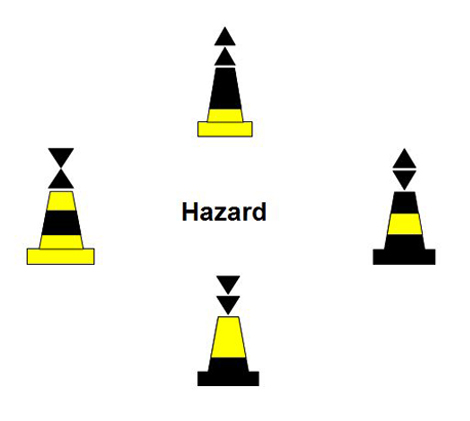

## BuoyShaped role

Just as the previous chapter, since the Physics::Navigation module has no built in concept of drawing a Buoy shape, we need a little raku to help. Here our shape is a little more intricate and includes colour bands on the body of the buoy and two top mark shapes.

In [4]:
role BuoyShaped {
    has $.apex = Point.new(200,50);
    has $!size = 200;

    sub make-bgnd {
        my $stroke := my $fill = "#0000ff40";
        my $width = 1024; my $height = 768;
        
        Rectangle.new( :$width , :$height, :$stroke, :$fill, origin => Point.new(0,0) );
    }

    sub make-marks( \x, \y, @shapes ) {
        my $stroke := my $fill = "black";
        my @elements; my @ys = [y,y+20];
        
        for ^2 -> \i {
            my $inverted = @shapes[i] eq 'Down' ?? True !! False;
            my \ay = $inverted ?? @ys[i]+12 !! @ys[i];
            
            @elements.push: Triangle.new( :$stroke, :$fill, :$inverted, 
                                          side => 15, apex => Point.new(x,ay) );
        }
        return @elements;
    }
    
    sub make-shim( \x, \y, \h, \d, $colour ) {
        my $stroke := my $fill = $colour;
        my @points = [ Point.new(x,  y),
                       Point.new(x+d,y+h),
                       Point.new(x,  y+h), ];
        Polygon.new( :$stroke, :$fill, :@points );
    }
    
    sub make-layer( \x, \y, $width, $height, $colour, :$shim ) {
        my $stroke := my $fill = $colour;
        
        my @elements;
        my \w := $width;
        my \h := $height;
        
        @elements.push: make-shim( (x - w/2), y, h, -10, $colour ) if $shim;
        @elements.push: make-shim( (x + w/2), y, h, +10, $colour ) if $shim;
        
        @elements.push: Rectangle.new( :$width, :$height, :$stroke, :$fill, 
                                        origin => Point.new((x - w/2),y), );
        return @elements;
    }

    method elements {
        #calculate co-ords relative to top of drawing, according to size
        my \s := $!size;
        my \dy = s / 4;
        
        my \x := $!apex.x;      #centre (vertical)
        my \y := $!apex.y;      #top (horizontal)

        my @widths = [ 80, 100, 120, 200 ];
        my @levels = [ 40+y, 40+y+dy, 40+y+2*dy, 40+y+3*dy ];
        my @fills  = @.colours[0].Str xx 4;
        
        if @.colours.elems == 2 { 
            @fills[2] = @fills[3] = @.colours[1].Str;
        } elsif @.colours.elems == 3 {
            @fills[1] = @.colours[1].Str;
            @fills[2] = @fills[3] = @.colours[2].Str;
        }

        my $bg     = make-bgnd;
        my $marks  = make-marks( x, y, @.shapes );
        my $top    = make-layer( x, @levels[0], @widths[0], dy , @fills[0], :shim );
        my $middle = make-layer( x, @levels[1], @widths[1], dy , @fills[1], :shim );
        my $bottom = make-layer( x, @levels[2], @widths[2], dy , @fills[2], :shim );
        my $base   = make-layer( x, @levels[3], @widths[3], dy*2/3 , @fills[3] );
                      
        [ $bg, |$top, |$middle, |$bottom, |$base, |$marks, ]
    }
}

(BuoyShaped)

## Define our Buoys

In [5]:
my $ncm = NorthCardinal.new( position => $pos-A );  say "$ncm";

NorthCardinal Buoy at (51°30.432′N, 000°7.158′W)
Colours:Black,Yellow. Shapes:Up,Up. Outline:None. Pattern:Layers.
Flashes quickly



In [6]:
my $wcm = WestCardinal.new( position => $pos-B );  say "$wcm";

WestCardinal Buoy at (51°30.324′N, 000°7.656′W)
Colours:Yellow,Black,Yellow. Shapes:Down,Up. Outline:None. Pattern:Layers.
Flashes quickly 9 times every 15 seconds



In [7]:
my $ecm = EastCardinal.new( position => $pos-C );  say "$ecm";

EastCardinal Buoy at (51°30.324′N, 000°6.66′W)
Colours:Black,Yellow,Black. Shapes:Up,Down. Outline:None. Pattern:Layers.
Flashes quickly 3 times every 10 seconds



In [8]:
my $scm = SouthCardinal.new( position => $pos-D );  say "$scm";

SouthCardinal Buoy at (51°30.216′N, 000°7.656′W)
Colours:Yellow,Black. Shapes:Down,Down. Outline:None. Pattern:Layers.
Flashes quickly 6 times plus one long every 15 seconds



A couple of useful mnemonics are:
- the ECM top marks look like an "Easter Egg"
- the WCM top marks look like a "W" sideways on

## Let's Pick One

In [16]:
my $cm := $wcm;     say $cm.position.Str;

(51°30.324′N, 000°7.656′W)


WestCardinal+{BuoyShaped}+{BuoyShaped}+{BuoyShaped}+{BuoyShaped} Buoy at (51°30.324′N, 000°7.656′W)
Colours:Yellow,Black,Yellow. Shapes:Down,Up. Outline:None. Pattern:Layers.
Flashes quickly 9 times every 15 seconds



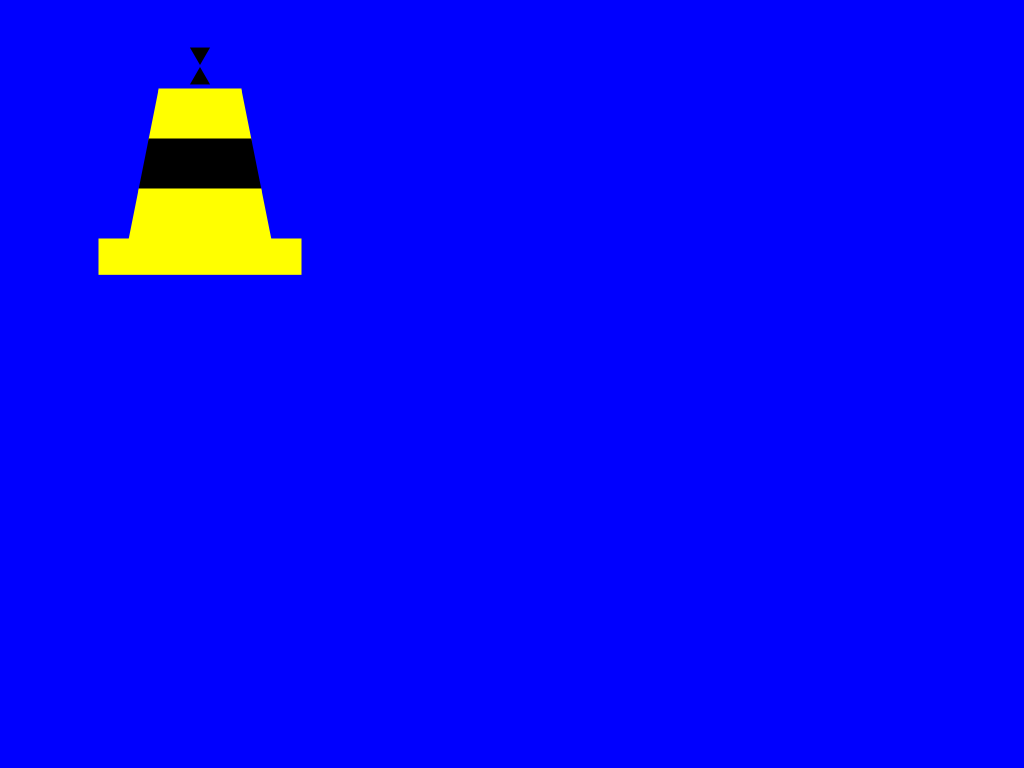

In [17]:
$cm does BuoyShaped;
"$cm".say;

my $drawing = Drawing.new( elements => $cm.elements );
$drawing.serialize.say;

Hint: you might like to try combining the two BuoyShaped roles from Chapter 7 and 8... or placing multiple buoys.